# Orçamento de Estado de 2023

```{epigraph}
Considerar todas as coisas como accidentes de uma illusão irracional, embora cada uma se apresente reacional para si mesma - nisto reside o princípio da sabedoria. Mas estes princípio da sabedoria não é mais que metade do entendimento das mesmas coisas. A outra parte do entendimento consiste no conhecimento d'essas coisas, na participação intima d'ellas.

-- Fernando Pessoa, Esp. 54A-p, in Yvette Centeno «Fernando Pessoa e a Filosofia Hermética»
```

A análise das votações e posicionamento relativo dos partidos tendo como base *exclusivamente* a forma como votam foi a base do trabalho anterior, análise essa que teve como fonte as votações das Iniciativas e Actividades.

O Orçamento de Estado para 2023 é o segundo aprovado pelo governo de maioria absoluta do Partido Socialista, emergido das eleições anecipadas de Janeiro de 2022.

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos)

São fundamentalmente feitas as seguintes análises:

1. Quantidade e tipo de propostas feitas, e resultado das mesmas
2. Apoio para as propostas de cada partido
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)

In [1]:
!pip3 install --user -q  matplotlib pandas seaborn sklearn 

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme(style="whitegrid", palette="pastel")

In [8]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

oe_url = "https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379395063734f6e5957316c626e52764a5449775a47386c4d6a4246633352685a4738765746596c4d6a424d5a576470633278686448567959533950525642796233427663335268633046736447567959574e68627a49774d6a4e50636935346257773d&fich=OEPropostasAlteracao2023Or.xml&Inline=true"
#oe_tree = ET.parse(urlopen(oe_url))
oe_file = './OEPropostasAlteracao2023Or.xml'
oe_tree = ET.parse(oe_file)

In [9]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

        oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print(vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [10]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df

ID     Nr                 Date Domain  \
0     19078  1763C  15/11/2022 15:47:00   None   
1     19077  1762C  15/11/2022 15:45:00   None   
2     19021  1761C  11/11/2022 21:24:00   None   
3     19020  1760C  11/11/2022 21:21:00   None   
4     19019  1759C  11/11/2022 21:07:00   None   
...     ...    ...                  ...    ...   
1857  17221     5C  28/10/2022 09:04:00   None   
1858  17220     4C  28/10/2022 09:03:00   None   
1859  17219     3C  28/10/2022 09:03:00   None   
1860  17218     2C  28/10/2022 09:02:00   None   
1861  17217     1C  28/10/2022 09:01:00   None   

                                Type                     State   GP  \
0            Aditamento (Artigo PPL)   Aprovado(a) em Plenário   PS   
1            Aditamento (Artigo PPL)   Aprovado(a) em Comissão   PS   
2     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
3            Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   
4            Aditamento (Artigo PPL)   Aprovado(a) em Plenário   PS   
...                              ...                       ...  ...   
1857         Aditamento (Artigo PPL)   Aprovado(a) em Comissão  PAN   
1858         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   
1859         Aditamento (Artigo PPL)  Rejeitado(a) em Plenário  PAN   
1860                          Emenda  Rejeitado(a) em Comissão  PAN   
1861         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   

                                               IniTitle            VoteDesc  \
0                     Atualização das pensões para 2023      Artigo 150.º-D   
1     Concessão e renovação simplificada de autoriza...      Artigo 150.º-C   
2     Transferências para políticas ativas de empreg...  N.º 3, Artigo 83.º   
3     Atualização da lista de espécies em risco e em...      Artigo 139.º-A   
4     Conclusão da Residência da Escola Superior de ...      Artigo 117.º-A   
...                                                 ...                 ...   
1857                        Combate à pobreza menstrual       Artigo 14.º-A   
1858                   Alterações ao Código do Trabalho      Artigo 195.º-A   
1859  Aditamento à lista I anexa ao Código do Impost...      Artigo 167.º-A   
1860  Alteração ao Código do Imposto sobre o Rendime...                 NaN   
1861  Criação de linha extraordinária de apoio às as...      Artigo 167.º-B   

     Partido Socialista Partido Social Democrata      Chega  \
0                 Favor                Abstenção     Contra   
1                 Favor                    Favor     Contra   
2                 Favor                Abstenção      Favor   
3                Contra                Abstenção  Abstenção   
4                 Favor                    Favor      Favor   
...                 ...                      ...        ...   
1857              Favor                Abstenção  Abstenção   
1858             Contra                   Contra     Contra   
1859             Contra                Abstenção  Abstenção   
1860             Contra                    Favor      Favor   
1861             Contra                   Contra      Favor   

     Iniciativa Liberal Partido Comunista Português Bloco de Esquerda  \
0             Abstenção                   Abstenção         Abstenção   
1             Abstenção                       Favor             Favor   
2                 Favor                   Abstenção         Abstenção   
3                 Favor                       Favor             Favor   
4             Abstenção                       Favor             Favor   
...                 ...                         ...               ...   
1857          Abstenção                   Abstenção             Favor   
1858             Contra                      Contra             Favor   
1859          Abstenção                   Abstenção             Favor   
1860              Favor                   Abstenção             Favor   
1861             Contra                   Abst

## As propostas: quantidade, aprovações, rejeições

Após obtermos e processarmos o ficheiro com as Propostas de Alteração podemos ter uma primeira ideia sobre a origem das propostas:

```{margin}
Em gráfico de barras:
```

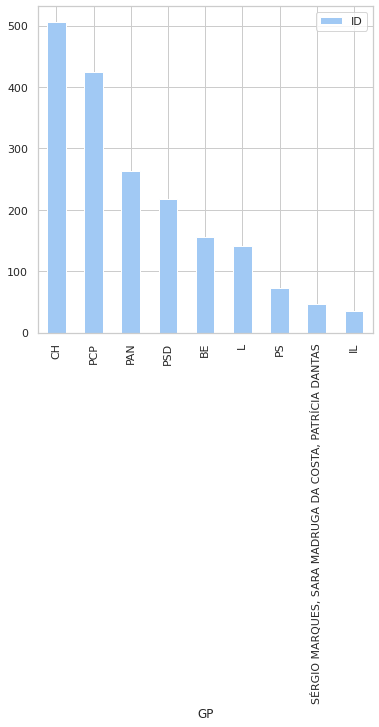

In [11]:
oe_df.groupby('GP')[['ID']].count().sort_values(by=['ID'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))
plt.show()


In [64]:
oe_df.groupby('GP')[['ID']].count().sort_values("ID", ascending=False)

ID
GP                                                     
CH                                                  522
PCP                                                 440
PAN                                                 263
PSD                                                 235
BE                                                  163
L                                                   144
PS                                                  106
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...   49
IL                                                   39

O resultado das propostas de cada partido (ou seja, se e como foram aprovadas ou rejeitadas):

In [65]:
pd.crosstab(oe_df.GP, oe_df.State)

State                                               Aprovado(a) Parcialmente em Comissão  \
GP                                                                                         
BE                                                                                     1   
CH                                                                                     0   
IL                                                                                     0   
L                                                                                      4   
PAN                                                                                    2   
PCP                                                                                    2   
PS                                                                                     0   
PSD                                                                                    1   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                     0   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                        5   
CH                                                                        0   
IL                                                                        1   
L                                                                        19   
PAN                                                                      30   
PCP                                                                       1   
PS                                                                       77   
PSD                                                                       5   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        0   

State                                               Aprovado(a) em Plenário  \
GP                                                                            
BE                                                                        0   
CH                                                                        0   
IL                                                                        0   
L                                                                         0   
PAN                                                                       0   
PCP                                                                       0   
PS                                                                       27   
PSD                                                                       0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        0   

State                                               Aprovado(a) por Unanimidade em Comissão  \
GP                                                                                            
BE                                                                                        0   
CH                                                                                        0   
IL                                                                                        1   
L                                                                                         3   
PAN                                                                                       0   
PCP                                                                                       1   
PS                                                                                        2   
PSD                                                                                       1   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                        0   

State                                               Aprovado(a) por Unanimidade em Plenário  \
GP                                                                                            
BE         

Uma das diferenças que pode ser observada é a passagem do Chega para o primeiro lugar, em termos de número de propostas. Este dado não se deve ao diminuir das propostas dos outros partidos (o PCP, que em OEs anteriores foi quem mais propostas apresentou, tem neste OE quase 100 propostas a mais que no anterior), mas pelo crescimento das do Chega, que passa de 309 para 506).

O Livre aumenta também significativamente o número das suas propostas (de 84 para 141), enquanto a Iniciativa Liberal reduz de forma relevante (de 127 para 35). Os restantes (PSD, BE, PAN) )apresentam valores semelhantes

In [67]:
pd.crosstab(oe_df.GP, oe_df.State).columns

ct = pd.crosstab(oe_df.GP, oe_df.State)[['Aprovado(a) por Unanimidade em Plenário',
                                         'Aprovado(a) por Unanimidade em Comissão',
                                         'Aprovado(a) em Plenário',
                                         'Aprovado(a) em Comissão',
                                         'Aprovado(a) Parcialmente em Comissão',
                                         'Rejeitado(a) em Plenário',
                                         'Rejeitado(a) em Comissão',
                                        ]]
ct

State                                               Aprovado(a) por Unanimidade em Plenário  \
GP                                                                                            
BE                                                                                        0   
CH                                                                                        0   
IL                                                                                        0   
L                                                                                         2   
PAN                                                                                       0   
PCP                                                                                       0   
PS                                                                                        0   
PSD                                                                                       0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                        0   

State                                               Aprovado(a) por Unanimidade em Comissão  \
GP                                                                                            
BE                                                                                        0   
CH                                                                                        0   
IL                                                                                        1   
L                                                                                         3   
PAN                                                                                       0   
PCP                                                                                       1   
PS                                                                                        2   
PSD                                                                                       1   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                        0   

State                                               Aprovado(a) em Plenário  \
GP                                                                            
BE                                                                        0   
CH                                                                        0   
IL                                                                        0   
L                                                                         0   
PAN                                                                       0   
PCP                                                                       0   
PS                                                                       27   
PSD                                                                       0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        0   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                        5   
CH                                                                        0   
IL                                                                        1   
L                                                                        19   
PAN                                                                      30   
PCP                                                                       1   
PS                                                                       77   
PSD                                                                       5   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        0   

State                                               Aprovado(a) Parcialmente em Comissão  \
GP                                                                          

A mesma informação em forma de gráfico de barras: o total de propostas de cada partido (ou deputados) com a distribuição do resultado das mesmas, ordenados pelo maior número de aprovações.

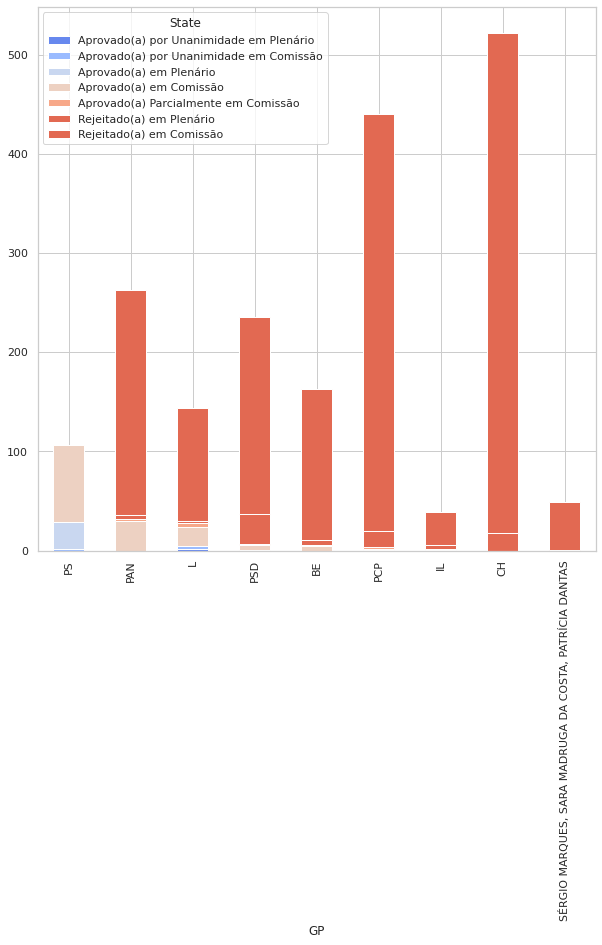

In [68]:
%matplotlib inline
#    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set()
sns.set_style("whitegrid")

## Sort by the "Approved" in the many ways it's possible
## sort by a separate aggregate value.
ct.sort_values(by=['Aprovado(a) em Comissão','Aprovado(a) por Unanimidade em Comissão','Aprovado(a) em Plenário','Aprovado(a) por Unanimidade em Plenário','Aprovado(a) Parcialmente em Comissão'], ascending=False,axis=0).plot(kind="bar", stacked=True, colormap=ListedColormap(sns.color_palette("coolwarm").as_hex()),figsize=(10,10))
plt.show()

Tendo em conta o resultado das propostas, alguns comentários:

* O maior número de propostas submetidas e também rejeitadas é do Chega, que não consegue aprovação de nenhuma proposta.
* O Livre e o PAN são os partidos que conseguem taxas de aprovação com alguma relevância.
* O PCP, com o segundo maior número de propostas, tem uma taxa de aprovação muito reduzida (apenas 4).
* BE e PSD aprovam ligeiramente mais, mas mesmo assim é residual.
* IL consegue 2 aprovações.


É, em vários aspectos, um resulta em linha com o orçamento anterior, na forma como a maioria absoluta do PS garante uma taxa de aprovação completa a propostas do PS, bem como uma aparente convergência (dentro do contexto) com PAN e Livre.

### Propostas aprovadas

E que propostas cada partido conseguiu aprovar? A utilização do título da iniciativa é aqui útil

In [19]:
from IPython.display import display, HTML

approved_oe = oe_df[oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ":", len(gp_df.index), " aprovadas.")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)



PS: 72  aprovadas.


GP  \
0    PS   
1    PS   
2    PS   
4    PS   
5    PS   
6    PS   
7    PS   
8    PS   
9    PS   
15   PS   
17   PS   
19   PS   
22   PS   
24   PS   
27   PS   
28   PS   
29   PS   
81   PS   
82   PS   
171  PS   
180  PS   
294  PS   
298  PS   
304  PS   
305  PS   
306  PS   
307  PS   
308  PS   
309  PS   
310  PS   
316  PS   
319  PS   
324  PS   
331  PS   
333  PS   
336  PS   
338  PS   
342  PS   
344  PS   
345  PS   
346  PS   
353  PS   
354  PS   
362  PS   
369  PS   
373  PS   
374  PS   
379  PS   
387  PS   
394  PS   
402  PS   
405  PS   
421  PS   
435  PS   
442  PS   
446  PS   
448  PS   
452  PS   
455  PS   
458  PS   
459  PS   
464  PS   
469  PS   
470  PS   
471  PS   
472  PS   
475  PS   
476  PS   
477  PS   
481  PS   
485  PS   
487  PS   

                                                                                                                                 IniTitle  \
0    Atualização das pensões para 2023                                                                                                      
1    Concessão e renovação simplificada de autorizações de residência                                                                       
2    Transferências para políticas ativas de emprego e formação profissional                                                                
4    Conclusão da Residência da Escola Superior de Desporto de Rio Maior                                                                    
5    Aeroporto da Horta                                                                                                                     
6    Alargamento da oferta de Profilaxia Pré Exposição                                                                                      
7    Integração do Sistema Híbrido de Perfusão Subcutânea Contínua de Insulina no Regime Geral do Medicamento                               
8    Alargamento do Programa Nacional de Promoção de Saúde Oral                                                                             
9    Comparticipação das fórmulas elementares que se destinem a crianças com alergia às proteínas do leite de vaca                          
15   Prorrogação prazo suspensivo de novas licenças para Alojamento Local                                                                   
17   Alteração à lei geral tributária                                                                                                       
19   Alteração da Lei n.º 50/2012, de 31 de agosto                                                                                          
22   Distribuição gratuita de bens de higiene pessoal feminina                                                                              
24   Reforço do apoio psicológico nas instituições de ensino                                                                                
27   Transferências orçamentais                                                                                                             
28   Alteração ao Código do Imposto Municipal sobre Imóveis                                                                                 
29   Amortização dos contratos de empréstimo                                                                                                
81   Formação de contratos no âmbito da Jornada Mundial da Juventude 2023                                                                   
82   Formação de contratos no âmbito da Jornada Mundial da Juventude 2023                                                                   
171  Alteração ao Estatuto dos Eleitos Locais                                                                                               
180  Alteração ao Código dos Impostos Especiais de Consumo                                                                                  
294  Alteração em sede de Imposto do Selo                                                          

L: 27  aprovadas.


GP  \
25   L   
173  L   
174  L   
184  L   
187  L   
190  L   
193  L   
199  L   
203  L   
214  L   
218  L   
219  L   
222  L   
313  L   
314  L   
330  L   
637  L   
704  L   
743  L   
744  L   
872  L   
879  L   
886  L   
889  L   
892  L   
898  L   
906  L   

                                                                                                                                   IniTitle  \
25   Promoção da Língua Mirandesa (promoçon de la Lhéngua Mirandesa)                                                                          
173  Promoção do transporte escolar e da mobilidade flexível, polivalente e ecológica                                                         
174  Passe Ferroviário Nacional                                                                                                               
184  Comparticipação de leites, fórmulas infantis e vacina anti-alérgica                                                                      
187  Encargos com nutrição entérica e parentérica                                                                                             
190  Bilha Solidária                                                                                                                          
193  Disponibilização de bombas de insulina para pessoas com diabetes de tipo 1                                                               
199  Contratação de recursos humanos para concretização das políticas públicas de habitação                                                   
203  Programa 3C - Casa, Conforto e Clima                                                                                                     
214  Programa de Mobilidade Sustentável Casa-Trabalho                                                                                         
218  Cartão +Cultura, +Cidadania                                                                                                              
219  Combate à Poluição Luminosa                                                                                                              
222  Apoio às Cooperativas de Habitação                                                                                                       
313  Produção de efeitos e vigência                                                                                                           
314  Complemento especial ao abono de família                                                                                                 
330  Estratégia Nacional e Programa para a Remoção de Infraestruturas Hidráulicas obsoletas                                                   
637  Base de dados sobre juntas médicas e estudo sobre a dispensa de avaliação                                                                
704  Violência Contra Pessoas com Deficiência                                                                                                 
743  Produção de efeitos e vigência                                                                                                           
744  Alteração ao Código do Imposto sobre o Valor Acrescentado                                                                                
872  Acessibilidade do Portal da Queixa Eletrónica                                                                                            
879  Estudo sobre Impacto da Menstruação                                                                                                      
886  Transferência para o Fundo de Salvaguarda do Património Cultural                                                                         
889  Atualização do Plano Nacional para o Alojamento no Ensino Superior com a identificação das necessidades dos estudantes com deficiência   
892  Livro Branco sobre Trabalho Sexual e Prostituição                                                                                        
898  

PAN: 28  aprovadas.


GP  \
70    PAN   
74    PAN   
100   PAN   
127   PAN   
128   PAN   
192   PAN   
271   PAN   
273   PAN   
390   PAN   
427   PAN   
468   PAN   
524   PAN   
820   PAN   
829   PAN   
832   PAN   
1032  PAN   
1070  PAN   
1817  PAN   
1819  PAN   
1825  PAN   
1832  PAN   
1835  PAN   
1836  PAN   
1853  PAN   
1854  PAN   
1855  PAN   
1856  PAN   
1857  PAN   

                                                                                                          IniTitle  \
70    Plano de Proteção e Despoluição do Rio Paiva                                                                   
74    Plano de Ação Nacional para a Gestão e Conservação de Tubarões e Raias                                         
100   Melhoria dos procedimentos consulares no pedido de registo de mudança da menção do sexo e do nome próprio      
127   Incentivo aos hábitos de leitura nos jovens adultos                                                            
128   Estudo sobre capturas indevidas de mamíferos e aves marinhas pelas redes de pesca e reforço da monitorização   
192   Apoios para o arranque e controlo de eucaliptos de crescimento espontâneo                                      
271   Gestão sustentável de habitats agrícolas                                                                       
273   Alteração à lista I anexa ao Código do Imposto sobre o Valor Acrescentado                                      
390   Estudo sobre o impacto da “Taxa Rosa” em Portugal                                                              
427   Espaço Gisberta - Resposta Integrada de Apoio à Vítima LGBTI                                                   
468   Plano Anual de Formação sobre bem-estar animal                                                                 
524   Taxa de carbono sobre as viagens aéreas em aeronaves com capacidade máxima de até 19 lugares                   
820   Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                  
829   Alteração à lista I anexa ao Código do Imposto sobre o Valor Acrescentado                                      
832   Alteração à lista I anexa ao Código do Imposto sobre o Valor Acrescentado                                      
1032  Atlas de risco das alterações climáticas                                                                       
1070  Realização de campanha anual de identificação gratuita dos animais de companhia                                
1817  Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas                                        
1819  Incentivo à introdução no consumo de veículos de baixas emissões                                               
1825  Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares                                       
1832  Alteração ao Decreto-Lei n.º 15/2022, de 14 de janeiro                                                         
1835  Alteração à lista I anexa ao Código do Imposto sobre o Valor Acrescentado                                      
1836  Centros de recuperação de animais selvagens                                                                    
1853  Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                  
1854  Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                  
1855  Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                  
1856  Centros de recolha oficial de animais, apoio à esterilização e à promoção do bem-estar animal                  
1857  Combate à pobreza menstrual                                                                                    

                                           VoteDesc  \
70    Artigo 135.º-A                                  
74    Artigo 143.º-A                                  
100   Artigo 142.º-A                     

PCP: 4  aprovadas.


GP  \
265   PCP   
531   PCP   
659   PCP   
1505  PCP   

                                                                                                          IniTitle  \
265   Alteração ao Código do Imposto sobre o Valor Acrescentado                                                      
531   Eliminação de barreiras arquitetónicas                                                                         
659   Atualização da caraterização e diagnóstico do estado de conservação dos valores naturais em áreas protegidas   
1505  Proteção das vítimas de violência doméstica (Alteração à Lei n.º 112/ 2009, de 16 de setembro)                 

            VoteDesc                                    State  
265   Artigo 166.º-A  Aprovado(a) por Unanimidade em Comissão  
531   Artigo 76.º-A   Aprovado(a) Parcialmente em Comissão     
659   Artigo 154.º-A  Aprovado(a) em Comissão                  
1505  Artigo 192.º-A  Aprovado(a) Parcialmente em Comissão

PSD: 7  aprovadas.


GP  \
335   PSD   
585   PSD   
837   PSD   
853   PSD   
854   PSD   
1161  PSD   
1164  PSD   

                                                                       IniTitle  \
335   Regime extraordinário de apoio a encargos suportados na produção agrícola   
585   Fiscalização prévia do Tribunal de Contas                                   
837   Alteração à Lei n.º 19/2022, de 21 de outubro                               
853   Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares    
854   Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas     
1161  Reforço de meios para a prevenção e combate ao tráfico de seres humanos     
1164  Reforço da prevenção e combate à violência contra as pessoas idosas         

                            VoteDesc                                    State  
335   Alínea d), N.º 1, Artigo 164.º  Aprovado(a) em Comissão                  
585   N.º 5, Artigo 147.º             Aprovado(a) em Comissão                  
837   Artigo 179.º-A                  Aprovado(a) em Comissão                  
853                                   Aprovado(a) em Comissão                  
854                                   Aprovado(a) em Comissão                  
1161  Artigo 18.º-B                   Aprovado(a) Parcialmente em Comissão     
1164  Artigo 18.º-A                   Aprovado(a) por Unanimidade em Comissão

BE: 6  aprovadas.


GP  \
662   BE   
667   BE   
710   BE   
1037  BE   
1038  BE   
1124  BE   

                                                                                IniTitle  \
662   Revisão das taxas de retenção para trabalhadores independentes                       
667   Inquérito nacional de caraterização sociodemográfica da população com deficiência    
710   Alteração ao Código Civil                                                            
1037  Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis   
1038  Norma revogatória de produção de efeitos em matéria fiscal                           
1124  Concretização da Estratégia Nacional de Compras Públicas Ecológicas                  

            VoteDesc                                 State  
662   Artigo 151.º-A  Aprovado(a) Parcialmente em Comissão  
667   Artigo 150.º-C  Aprovado(a) em Comissão               
710   Artigo 191.º-A  Aprovado(a) em Comissão               
1037                  Aprovado(a) em Comissão               
1038  Artigo 190.º-A  Aprovado(a) em Comissão               
1124  Artigo 14.º-A   Aprovado(a) em Comissão

IL: 2  aprovadas.


GP  \
738   IL   
1014  IL   

                                                                                             IniTitle  \
738   Regulamentação dos Sistemas de Depósito e Reembolso                                               
1014  Antecipação dos resultados do Concurso Nacional de Acesso e Ingresso no Ensino Superior Público   

            VoteDesc                                    State  
738   Artigo 138.º-A  Aprovado(a) em Comissão                  
1014  Artigo 121.º-A  Aprovado(a) por Unanimidade em Comissão

## As votações

Até agora contabilizámos as propostas de alteração e o seu resultado; se em geral existe uma votação por proposta de alteração isso nem sempre acontece: existem propostas de alteração que dão origem a mais que uma votação. As votações contêm informação adicional que é interessante para de determinar de forma directa o teor das propostas (nomeadamente o título) e também a forma como os diferentes partidos e deputados votaram: se ao nível das propostas temos o resultado final, com as votações podemos saber como atingiram esse fim.

Após processarmos as votações enriquecemos o _dataframe_ com informação adicional. do qual a seguinte selecção é um exemplo: note-se o maior numero de colunas com informação adicional sobre cada votação.

In [38]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.getroot().findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "SubDescricao":
                    oe_dict["SubDesc"] = vote_el.text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

            oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print("Voting sessions:", vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [39]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df
oe_df["VoteDesc"] = oe_df["VoteDesc"] + ": " + oe_df["SubDesc"]
oe_df.drop(['SubDesc'],axis=1,inplace=True)
oe_df

ID     Nr                 Date Domain  \
0     19078  1763C  15/11/2022 15:47:00   None   
1     19078  1763C  15/11/2022 15:47:00   None   
2     19077  1762C  15/11/2022 15:45:00   None   
3     19021  1761C  11/11/2022 21:24:00   None   
4     19020  1760C  11/11/2022 21:21:00   None   
...     ...    ...                  ...    ...   
1956  17219     3C  28/10/2022 09:03:00   None   
1957  17219     3C  28/10/2022 09:03:00   None   
1958  17218     2C  28/10/2022 09:02:00   None   
1959  17218     2C  28/10/2022 09:02:00   None   
1960  17217     1C  28/10/2022 09:01:00   None   

                                Type                     State   GP  \
0            Aditamento (Artigo PPL)   Aprovado(a) em Plenário   PS   
1            Aditamento (Artigo PPL)   Aprovado(a) em Plenário   PS   
2            Aditamento (Artigo PPL)   Aprovado(a) em Comissão   PS   
3     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
4            Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   
...                              ...                       ...  ...   
1956         Aditamento (Artigo PPL)  Rejeitado(a) em Plenário  PAN   
1957         Aditamento (Artigo PPL)  Rejeitado(a) em Plenário  PAN   
1958                          Emenda  Rejeitado(a) em Comissão  PAN   
1959                          Emenda  Rejeitado(a) em Comissão  PAN   
1960         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   

                                               IniTitle  \
0                     Atualização das pensões para 2023   
1                     Atualização das pensões para 2023   
2     Concessão e renovação simplificada de autoriza...   
3     Transferências para políticas ativas de empreg...   
4     Atualização da lista de espécies em risco e em...   
...                                                 ...   
1956  Aditamento à lista I anexa ao Código do Impost...   
1957  Aditamento à lista I anexa ao Código do Impost...   
1958  Alteração ao Código do Imposto sobre o Rendime...   
1959  Alteração ao Código do Imposto sobre o Rendime...   
1960  Criação de linha extraordinária de apoio às as...   

                                               VoteDesc Partido Socialista  \
0     Artigo 150.º-D: Atualização das pensões para 2023              Favor   
1     Artigo 150.º-D: Atualização das pensões para 2023              Favor   
2     Artigo 150.º-C: Concessão e renovação simplifi...              Favor   
3                                                   NaN              Favor   
4     Artigo 139.º-A: Atualização da lista de espéci...             Contra   
...                                                 ...                ...   
1956  Artigo 167.º-A: Aditamento à lista I anexa ao ...             Contra   
1957  Artigo 167.º-A: Aditamento à lista I anexa ao ...             Contra   
1958                                                NaN             Contra   
1959                                                NaN             Contra   
1960  Artigo 167.º-B: Criação de linha extraordinári...             Contra   

     Partido Social Democrata      Chega Iniciativa Liberal  \
0                   Abstenção     Contra          Abstenção   
1                   Abstenção     Contra          Abstenção   
2                       Favor     Contra          Abstenção   
3                   Abstenção      Favor              Favor   
4                   Abstenção  Abstenção              Favor   
...                       ...        ...                ...   
1956                Abstenção  Abstenção          Abstenção   
1957                Abstenção  Abstenção          Abstenção   
1958                    Favor      Favor              Favor   
1959                    Favor      Favor              Favor   
1960                   Contra      Favor             Contra   

     Partido Comunista Português Bloco de Esquerda Pessoas-Animais-Natureza  \
0                      Abstenção         Abstenção                Abstenç

In [40]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
oe_dfr = oe_df.rename(columns={'Partido Socialista': 'PS', 
                               'Partido Social Democrata': 'PSD',
                               'Bloco de Esquerda': 'BE',
                               'Partido Comunista Português': 'PCP',
                               'Pessoas-Animais-Natureza': 'PAN',
                               'Chega': 'CH',
                               'Iniciativa Liberal':'IL',
                               'Livre':'L',                               
                              })
oe_dfr.head()


ID     Nr                 Date Domain                            Type  \
0  19078  1763C  15/11/2022 15:47:00   None         Aditamento (Artigo PPL)   
1  19078  1763C  15/11/2022 15:47:00   None         Aditamento (Artigo PPL)   
2  19077  1762C  15/11/2022 15:45:00   None         Aditamento (Artigo PPL)   
3  19021  1761C  11/11/2022 21:24:00   None  Aditamento (Números e Alíneas)   
4  19020  1760C  11/11/2022 21:21:00   None         Aditamento (Artigo PPL)   

                      State   GP  \
0   Aprovado(a) em Plenário   PS   
1   Aprovado(a) em Plenário   PS   
2   Aprovado(a) em Comissão   PS   
3   Aprovado(a) em Comissão   PS   
4  Rejeitado(a) em Comissão  PAN   

                                            IniTitle  \
0                  Atualização das pensões para 2023   
1                  Atualização das pensões para 2023   
2  Concessão e renovação simplificada de autoriza...   
3  Transferências para políticas ativas de empreg...   
4  Atualização da lista de espécies em risco e em...   

                                            VoteDesc      PS        PSD  \
0  Artigo 150.º-D: Atualização das pensões para 2023   Favor  Abstenção   
1  Artigo 150.º-D: Atualização das pensões para 2023   Favor  Abstenção   
2  Artigo 150.º-C: Concessão e renovação simplifi...   Favor      Favor   
3                                                NaN   Favor  Abstenção   
4  Artigo 139.º-A: Atualização da lista de espéci...  Contra  Abstenção   

          CH         IL        PCP         BE        PAN          L  \
0     Contra  Abstenção  Abstenção  Abstenção  Abstenção  Abstenção   
1     Contra  Abstenção  Abstenção  Abstenção  Abstenção  Abstenção   
2     Contra  Abstenção      Favor      Favor      Favor      Favor   
3      Favor      Favor  Abstenção  Abstenção      Favor      Favor   
4  Abstenção      Favor      Favor      Favor      Favor      Favor   

                V_Date        Result PATRÍCIA DANTAS(PSD)  
0  23/11/2022 00:00:00   Aprovado(a)                  NaN  
1  23/11/2022 00:00:00   Aprovado(a)                  NaN  
2  23/11/2022 00:00:00   Aprovado(a)                  NaN  
3  21/11/2022 00:00:00   Aprovado(a)               Contra  
4  21/11/2022 00:00:00  Rejeitado(a)                  NaN

Para a análise das votações escolhemos um subconjunto alargado dos autores das propostas, isto porque as propostas de deputados individuais ou em grupo necessitaria de um tratamento mais complexo: consideramos todos os grupos parlamentos e deputados únicos de partido (Livre).

O resultado é uma tabela com a indicação do autor da proposta onde se integra a votação e os votos dos partidos.

In [41]:
mycol  = ['GP', 'BE', 'PCP','L','PS', 'PAN', 'PSD','IL', 'CH' ]
parties   = ['BE', 'PCP','L','PS', 'PAN','PSD','IL', 'CH']
df=oe_dfr

submissions_ini = df[mycol]
submissions_ini.head()

GP         BE        PCP          L      PS        PAN        PSD  \
0   PS  Abstenção  Abstenção  Abstenção   Favor  Abstenção  Abstenção   
1   PS  Abstenção  Abstenção  Abstenção   Favor  Abstenção  Abstenção   
2   PS      Favor      Favor      Favor   Favor      Favor      Favor   
3   PS  Abstenção  Abstenção      Favor   Favor      Favor  Abstenção   
4  PAN      Favor      Favor      Favor  Contra      Favor  Abstenção   

          IL         CH  
0  Abstenção     Contra  
1  Abstenção     Contra  
2  Abstenção     Contra  
3      Favor      Favor  
4      Favor  Abstenção

Com esta informação é possível determinar os padrões de votação; o diagrama seguinte mostra a relação entre cada par de partidos: no eixo horizontal quem propõe, e no vertical como votaram:

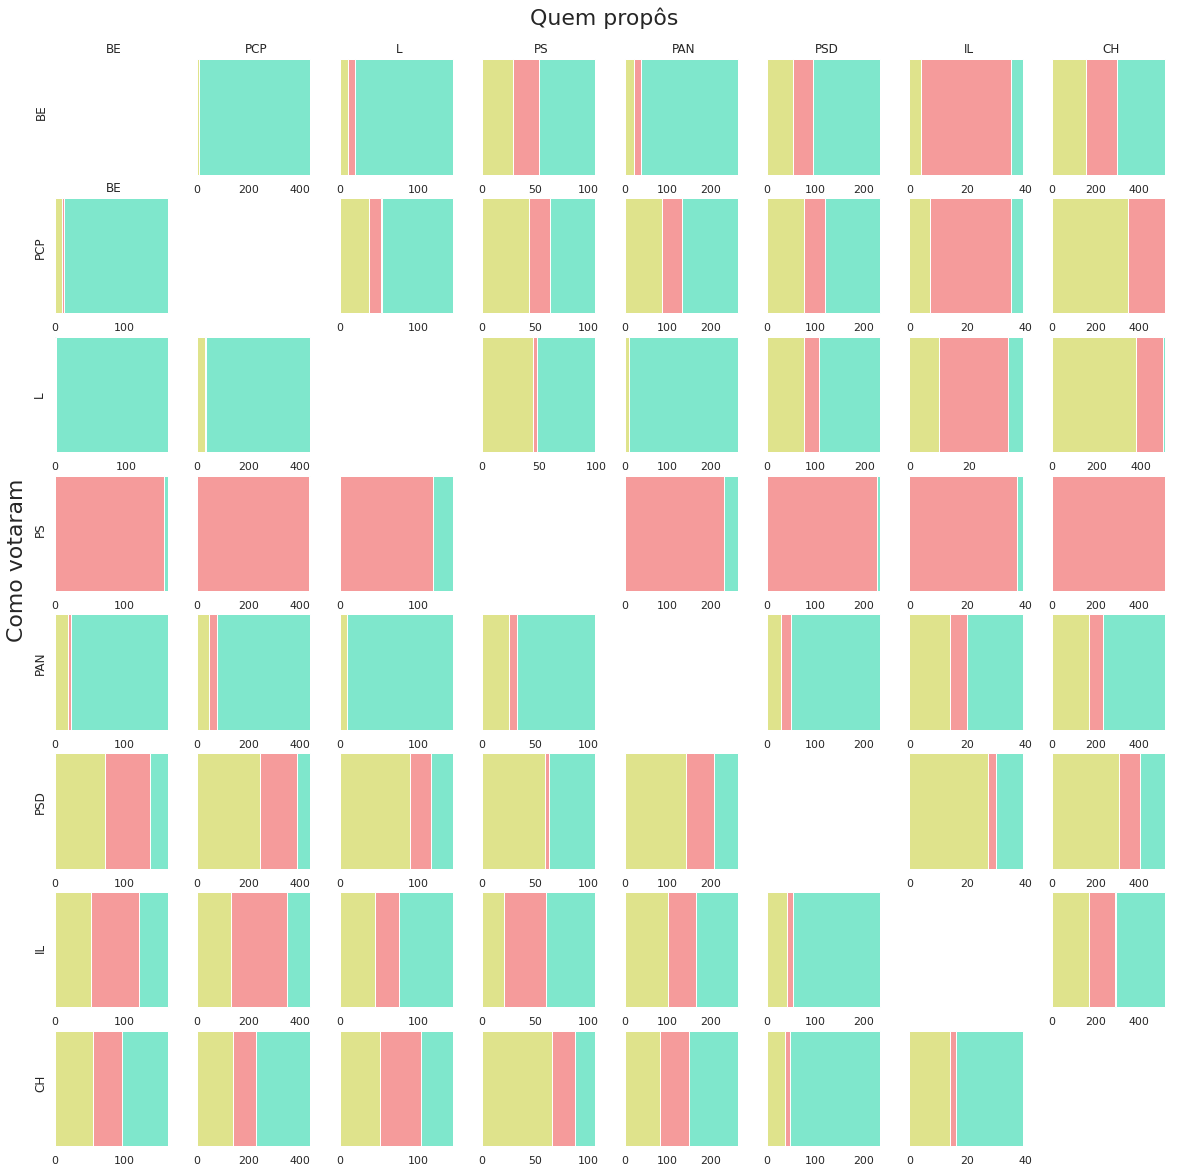

In [42]:
parties   = ['BE', 'PCP','L','PS', 'PAN','PSD', 'IL','CH']
gpsubs = submissions_ini

cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#DFE38C","#F59B9B","black","#7FE7CC" ]
cmap = ListedColormap(colors)

spn = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axes = axes.ravel()
for party in parties:
    for p2 in parties:
        sns.set_style("white")
        subp = gpsubs[gpsubs['GP'] == p2][[party]]
        sp = subp.fillna("Ausência").apply(pd.Series.value_counts)
        d = pd.DataFrame(columns=["GP","Abstenção", "Contra", "Ausência","Favor"]).merge(sp.T, how="right").fillna(0)
        d["GP"] = party
        d = d.set_index("GP")
        d = d[["Abstenção", "Contra", "Ausência","Favor"]]
        if p2 != party:
            sns.despine(left=True, bottom=True)
            if spn < 9:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap, title=p2,use_index=False,ax=axes[spn])
            else:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            axes[spn].get_legend().remove()
            plt.ylim(-4.5, axes[spn].get_yticks()[-1] + 0.5)
        else:
            axes[spn].set_xticks([])
            #d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            #axes[spn].get_legend().remove()
            if spn < 8:
                axes[spn].set_title(p2)
        axes[spn].set_yticks([])
        ## Why? Who knows? Certainly not me. This is likely a side-effect of using a single axis through .ravel
        if spn%8 == 0:
            if spn != 0:
                text = axes[spn].text(-30,0,party,rotation=90)
            else:
                text = axes[spn].text(-0.17,0.5,party,rotation=90)
        #print(party, p2)
        #print(d)
        #print("-------------------------_")
        spn += 1

#axes[11].set_axis_off()
text = axes[0].text(4,1.3,"Quem propôs",rotation=0,fontsize=22)
text = axes[0].text(-0.4,-4,"Como votaram",rotation=90,fontsize=22)

#fig.tight_layout()
plt.show()

Uma outra visualização, menos condensada mas com maior clareza quantitativa: para cada partido é criado um gráfico de barras, ordenado pelos votos favoráveis, com  comportamento de votos dos restantes para com as suas propostas.

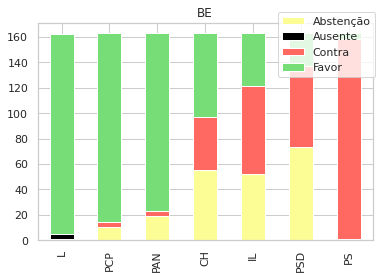

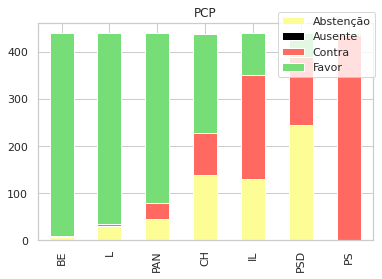

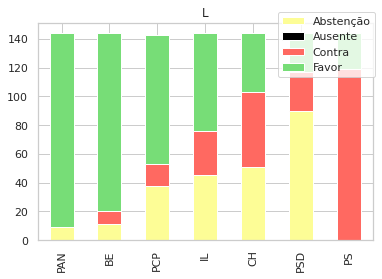

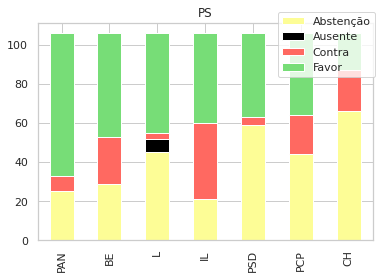

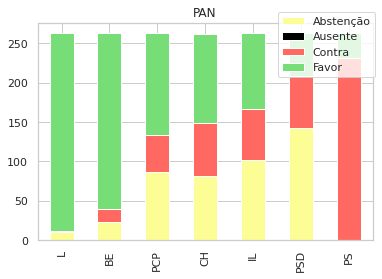

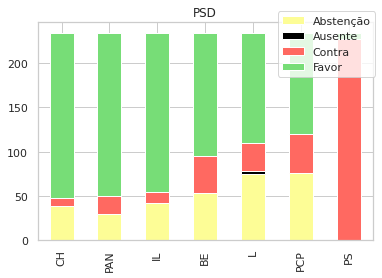

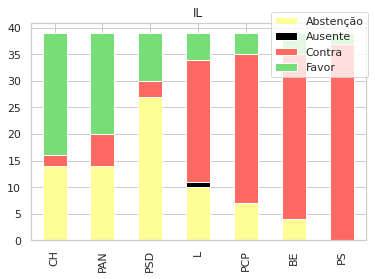

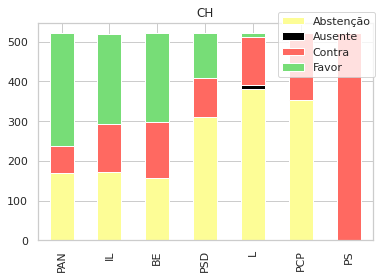

In [44]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
parties   = ['BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH']

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#fdfd96",  "black","#ff6961","#77dd77", ]
cmap = ListedColormap(colors)

#spn = 0
#axes = axes.ravel()

for party in parties:
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap,)
    plt.legend(loc='center left',  bbox_to_anchor=(0.7, 0.9),)
    plt.show()

plt.show()

## Dendograma e distância

Com base nas votações obtemos a distância euclideana entre todos os partidos (a distância entre todos os pares possíveis, considerado todas as votações), e com base nela um dendograma que indica a distância entre eles.

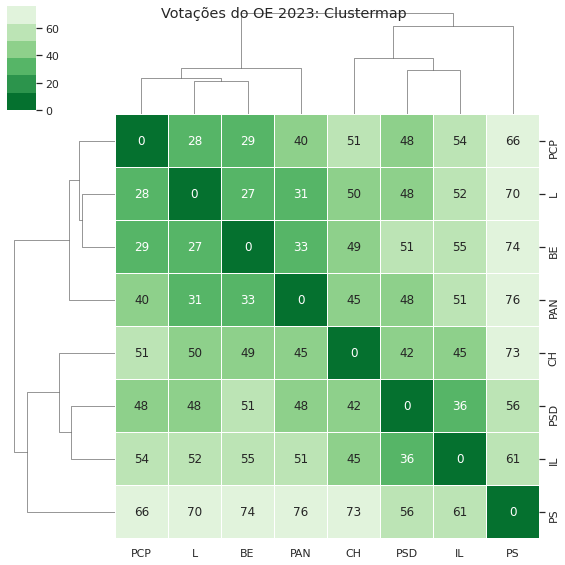

In [45]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import numpy as np
votes_hm = oe_dfr[['BE', 'PCP', 'L','PS', 'PAN', 'PSD','IL', 'CH']]
votes_hmn = votes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

## Affinity matrix
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)

#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Greens_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Votações do OE 2023: Clustermap')

plt.show()

```{margin} Votos idênticos vs. distância de votos

Por vezes o conceito de distância, votos idênticos e propostas aprovadas parece confuso. Adicionamos aqui o número de votos exactamente iguais. Estes dados são dos mais populares, talvez por serem muito directo na mensagem que transmitem.

Fica a ressalva: a consideração apenas dos votos "idênticos" desconsidera completamente a diferença entre votar Contra e Abstenção. Esta dimensão irá ser capturada na matriz de distâncias. Por outro lado, é também independente do número de propostas aprovadas: um partido pode estar mais "longe" (por ter votado mais vezes de forma diferente) e ter um número de propostas aprovada maior (por ter tido, nas suas propostas, a coincidência dos votos do PS, neste caso) do que um partido mais "próximo" (número de votações coincidentes maiores) mas que, nas propostas que fez, teve os votos contra do partido maioritário.
```

In [46]:
pv_list = []
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'font-weight: bold;')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv.style.apply(highlight_diag, axis=None)

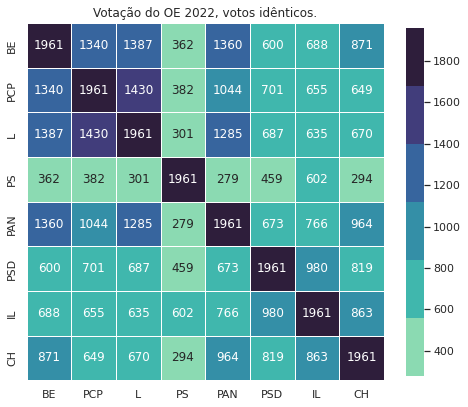

In [47]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Votação do OE 2023, votos idênticos.')

plt.show()

## MDS: *Multidimensional scaling*

Tendo como base os votos no OE podemos utilizar a mesma técnica que empregámos na análise de toda a legislatura. Para identificar grupos usamos (mais uma vez, como no trabalho original, e presente nos Apêndices) *Spectral scaling*, definindo 4 grupos.

In [31]:

for area in oe_df["Domain"].unique():
    varea=oe_dfr[oe_dfr["Domain"] == area]

    avotes_hm = varea[['BE', 'PCP' , 'L', 'PS', 'PAN', 'PSD','IL','CH']]
    avotes_hmn = avotes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0) 
    if avotes_hmn.shape[0] < 10:
        continue
    avotes_t = avotes_hmn.transpose()
    apwdist = pdist(avotes_t, metric='euclidean')
    
    adistmat = pd.DataFrame(
        squareform(apwdist), # pass a symmetric distance matrix
        columns = avotes_t.index,
        index = avotes_t.index)
    adistmat_mm=((adistmat-adistmat.min().min())/(adistmat.max().max()-adistmat.min().min()))*1
    
    aaffinmat_mm = pd.DataFrame(1-adistmat_mm, adistmat.index, adistmat.columns)

    asc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(aaffinmat_mm)
    asc_dict = dict(zip(adistmat,asc))   
    
    amds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
    aresults = amds.fit(adistmat_mm.values)
    acoords = aresults.embedding_
    
    sns.set()
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(8,8))

    plt.title(area + "(n=" + str(avotes_hmn.shape[0]) +  ")", fontsize=14, fontweight="bold")

    for label, x, y in zip(adistmat_mm.columns, acoords[:, 0], acoords[:, 1]):
        ax.scatter(x, y, c = "C"+str(asc_dict[label]), s=250)
        #ax.scatter(x, y, s=250)
        ax.axis('equal')
        ax.annotate(label,xy = (x-0.02, y+0.025))
    plt.show()
    print(asc_dict)

In [32]:
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

pd.DataFrame.from_dict(sc_dict, orient='index', columns=["Group"]).T

BE  PCP  L  PS  PAN  PSD  IL  CH
Group   1    1  1   0    1    2   2   2

São resultados, mais uma vez, idênticos ao da votação anterior, com o PS individualizado e separado de um grupo à sua esquerda, e outro à sua direita.

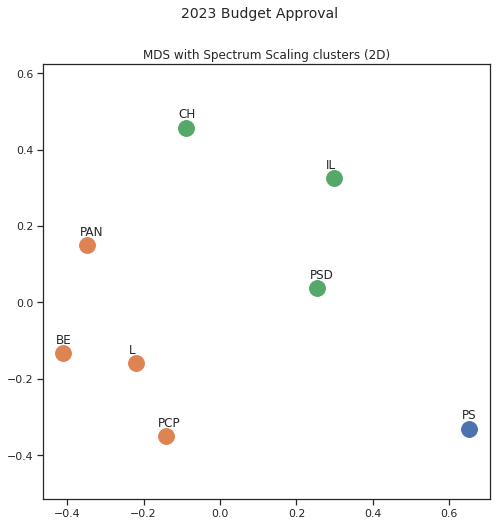

In [60]:
from sklearn.manifold import MDS
import random
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=60, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('2023 Budget Approval', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

Também o MDS é muito semelhante ao da votação anterior

Uma visualização em 3D permtie uma visão diferente, com mais uma dimensão:

In [34]:
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 700,
    height = 700,
    title = "OE 2023: 3D MDS",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
plot(fig, filename = 'oe_3d_mds.html')
display(HTML('oe_3d_mds.html'))

## Palavras finais


Esta análise demonstra como a utilização de dados abertos pode, uma vez mais, facilitar a análise da actividade parlamentar por parte dos eleitores; as ilações políticas que se podem tirar são variadas e, se é verdade que existem limitações várias a ter em conta, tal como no trabalho relativo à análise das votações parlamentares parecem emergir padrões que parecem reflectir tendências e agrupamentos que estão presentes no discurso político.

Sugere-se uma leitura comparada da análise feita, exactamente nos mesmos moldes, para os OEs anteriores: se aqui e ali formos fazendo referências ao que mudou e se manteve, mais há por explorar nessa dimensão comparativa.